<a href="https://colab.research.google.com/github/samleonnn/waste-segregation/blob/main/WasteSegregation_TransferLearning_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HerAi Model Development

The following code shows how to classify images of waste. We are working on the multiclass classification to recognize the organic, recyclable, or non-recyclable waste image.

### Read Data from Google Drive and Un-archive Dataset File
This `.ipynb` file is designed for the Google Colab environment. Please adjust several things depending on your working environment.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Capstone C22-PC414/AllMainData_v3.zip", "r")
zip_ref.extractall("/tmp")
zip_ref.close()

### Import Libraries

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Imported Dataset and Data Pre-Processing
We are working on an image dataset, therefore, we use `ImageDataGenerator` to allow us to perform image augmentation while training the model. In our dataset, we have 2 (two) directories called TRAIN and VAL directories. We do image augmentation only for the TRAIN dataset to create new data from existing data. Image augmentation that we implement are `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, `zoom_range`, and `horizontal_flip`. For both directories, we implement normalization (`rescale = 1./255.`) to reduce the computation of high numeric values. 
We also split the VAL dataset in half for `validation_data` and the rest for the test dataset. 

We use the `flow_from_directory()` function to load our images dataset easily referring to the directory and label our data based on their subdirectories. Since the images are not in the same size, we resize the image input into `(224, 224)` size.

For your information, our dataset contains:
- `Non-Recyclable` category: `7,000` Train images + `2,324` Validation images
- `Organic` category: `7,249` Train images + `1,475` Validation images
- `Recyclable` category: `7,000` Train images + `2,624` Validation images

Total data: `21,249` Train images and `6,423` Validation images

In [4]:
TRAIN_DIR = "/tmp/AllMainData_v3/TRAIN"
VAL_DIR  = "/tmp/AllMainData_v3/VAL"

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, 
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(directory = TRAIN_DIR,
                                    batch_size = 128, 
                                    class_mode = "categorical",
                                    target_size = (224, 224))

validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.5)

validation_generator = validation_datagen.flow_from_directory(directory = VAL_DIR,
                                            batch_size = 128, 
                                            class_mode = "categorical",
                                            target_size = (224, 224),
                                            subset = "training",
                                            shuffle = False)

test_generator = validation_datagen.flow_from_directory(directory = VAL_DIR,
                                            batch_size = 128, 
                                            class_mode = "categorical",
                                            target_size = (224, 224),
                                            subset = "validation",
                                            shuffle = False)

Found 21249 images belonging to 3 classes.
Found 3212 images belonging to 3 classes.
Found 3211 images belonging to 3 classes.


### Dataset Category Label
We can see that our dataset contains 3 categories.
* Label `0` refer to `Non-Recyclable`
* Label `1` refer to `Organic`
* Label `2` refer to `Recyclable`

The order of label is created when `flow_from_directory()` function called above and in alphabetical order.

In [6]:
print(train_generator.class_indices)

{'Non-Recyclable': 0, 'Organic': 1, 'Recyclable': 2}


### Visualize Image and the Label
We can see several images in our `TRAIN` dataset and see the real label of the image in the following cell. The following cell is to check that we are loading the correct data for training.

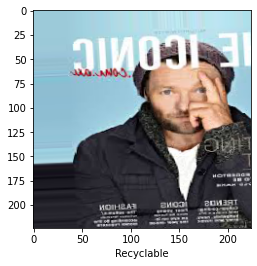

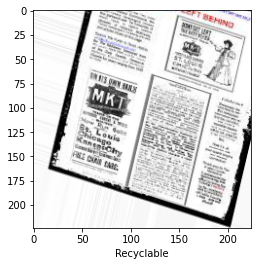

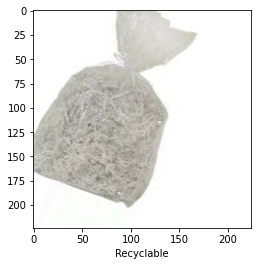

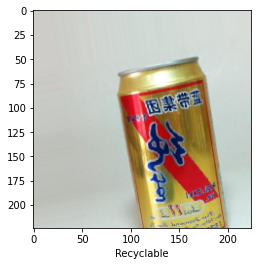

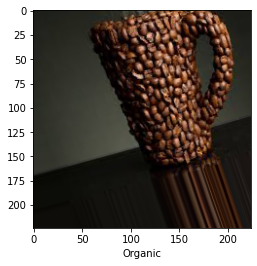

In [7]:
class_names = ["Non-Recyclable", "Organic", "Recyclable"]
x, y = train_generator.next()

for i in range(5):
    image = x[i]
    label = np.argmax(y[i])
    plt.xlabel(class_names[label])
    plt.imshow(image)
    plt.show()

### Create Base Model from Pre-Trained MobileNet
We use MobileNet as our base model for Transfer Learning because it is lightweight in its architecture. We decide to freeze all layers in the MobileNet to take knowledge from MobileNet that has been trained on the ImageNet dataset. We set the input shape into `(224, 224, 3)` means the image size is equal to `(224, 224)` and has 3 color channels. We only take the convolution knowledge or convolutional base of MobileNet by set the `include_top` argument into `False`. We are not including the built-in classification layers. Please see the following summary for details.

In [8]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras import layers

pre_trained_model = MobileNet(weights = 'imagenet',
                          include_top = False,
                          input_shape = (224, 224, 3))

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [18]:
print('last layer output shape: ', pre_trained_model.output_shape)
last_output = pre_trained_model.output

last layer output shape:  (None, 7, 7, 1024)


### Add New Model on Top
We add our own model on top of the MobileNet model to classify our data. First, we put the `GlobalAveragePooling2D` layer after the base model, i.e MobileNet Convolutional Base. We use the `GlobalAveragePooling2D` layer instead of `Flatten` because it is perform better on the classification tasks. `GlobalAveragePooling2D` layer allows us to take only one feature for each feature map by averaging every element of the feature map. Then, we add the `Dense` layer, a fully-connected layer, with `1024` units and activated by a `ReLU` activation function. Continue by adding the `Dense` layer with `512` units and activated by a `ReLU` activation function and set a `Dropout` layer of `0.2` to prevent overfitting on the training data. We add another `Dense` layer with `256` units and activated by a `ReLU` activation function and end with the prediction layer with `3` units and activated by the `Softmax` activation function for multiclass classification. Please refer to the following cell for a model summary in detail.

In [19]:
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dense(3, activation = 'softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

### Compile the Model
We decided to use `tf.keras.optimizers.Adam` optimizer for our model and `tf.keras.losses.CategoricalCrossentropy` loss function as-is. We use `tf.keras.losses.CategoricalCrossentropy` loss function because there are 3 (three) classes and represented in `one_hot` encoded representation. We also set the `metrics` argument to see the training and validation accuracy for each training epoch. Then, we compile it.

In [20]:
opt = "adam"

model.compile(optimizer = opt,
            loss = "categorical_crossentropy",
            metrics = ['accuracy']) 

### Train the Model
We pass the `train_generator` containing TRAIN data that is already normalized and augmented. We run the training for 10 epochs and we also pass the `validation_generator` containing half of the VAL data to check the `val_accuracy` for each epoch.

In [21]:
history = model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                    validation_data = validation_generator)

Epoch 1/10
167/167 [==============================] - 305s 2s/step - loss: 0.3937 - accuracy: 0.8388 - val_loss: 0.4164 - val_accuracy: 0.8300
Epoch 2/10
167/167 [==============================] - 300s 2s/step - loss: 0.2753 - accuracy: 0.8954 - val_loss: 0.6782 - val_accuracy: 0.7768
Epoch 3/10
167/167 [==============================] - 301s 2s/step - loss: 0.2642 - accuracy: 0.8986 - val_loss: 0.3570 - val_accuracy: 0.8717
Epoch 4/10
167/167 [==============================] - 302s 2s/step - loss: 0.2102 - accuracy: 0.9206 - val_loss: 0.3682 - val_accuracy: 0.8636
Epoch 5/10
167/167 [==============================] - 305s 2s/step - loss: 0.1877 - accuracy: 0.9294 - val_loss: 0.3185 - val_accuracy: 0.8761
Epoch 6/10
167/167 [==============================] - 305s 2s/step - loss: 0.1703 - accuracy: 0.9361 - val_loss: 0.3118 - val_accuracy: 0.8870
Epoch 7/10
167/167 [==============================] - 305s 2s/step - loss: 0.1479 - accuracy: 0.9460 - val_loss: 0.3258 - val_accuracy: 0.8839

### Visualizing Training Progress
We plot the training progress for loss and accuracy on the training and validation sets. As we can see, we are approaching better results. At the end of 10 epochs, we got `95.34%` training accuracy and `90.04%` validation accuracy.

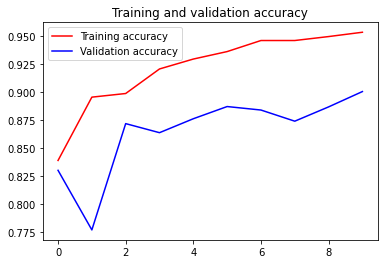

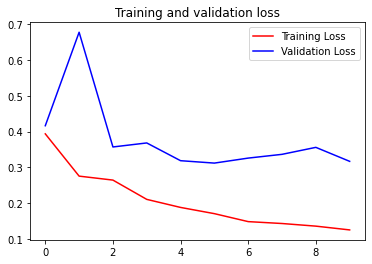

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model Evaluation
We also evaluate the model on test data inside the `test_generator` variable containing another half of the VAL dataset. We achieve `93.93%` test accuracy and the detail is as follow.

In [23]:
model.evaluate(test_generator)

26/26 [==============================] - 16s 611ms/step - loss: 0.1708 - accuracy: 0.9393


[0.17076176404953003, 0.9392712712287903]

### Plotting Confusion Matrix
In order to make sure that our model behaves well, we can see the following confusion matrix for `validation_generator` and `test_generator`. As the following result, we can see that our model behaves really well in predicting `organic` waste images, but there is still room for improvement to enhance the accuracy for `recyclable` and `non-recyclable` waste images. Overall, it still performs and behaves well in predicting the image.

Confusion Matrix


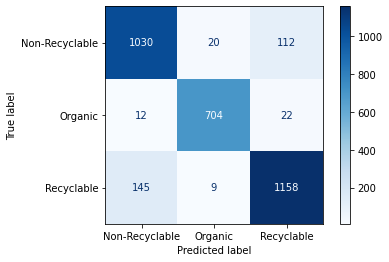


Classification Report
                precision    recall  f1-score   support

Non-Recyclable       0.87      0.89      0.88      1162
       Organic       0.96      0.95      0.96       738
    Recyclable       0.90      0.88      0.89      1312

      accuracy                           0.90      3212
     macro avg       0.91      0.91      0.91      3212
  weighted avg       0.90      0.90      0.90      3212



In [24]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ["Non-Recyclable", "Organic", "Recyclable"]
cm = confusion_matrix(validation_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))   

Confusion Matrix


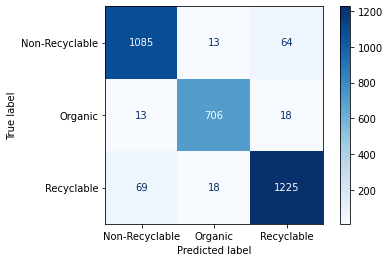


Classification Report
                precision    recall  f1-score   support

Non-Recyclable       0.93      0.93      0.93      1162
       Organic       0.96      0.96      0.96       737
    Recyclable       0.94      0.93      0.94      1312

      accuracy                           0.94      3211
     macro avg       0.94      0.94      0.94      3211
  weighted avg       0.94      0.94      0.94      3211



In [25]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ["Non-Recyclable", "Organic", "Recyclable"]
cm = confusion_matrix(test_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))   

### Export Model in Saved Model Format
We use the `model.save()` method to save our model in SavedModel format in order to be used in other development such as converting our model into a `.tflite` file.

In [26]:
save_path = "/content/drive/MyDrive/Capstone C22-PC414/wsmodel-24052022-mobilenet+GAP10"
model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone C22-PC414/wsmodel-24052022-mobilenet+GAP10/assets
